In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [7]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-08-29 12:00:00+00:00 ETH      1448.478571   1493.548571   1447.431429   
                          LINK        6.364701      6.560979      6.363478   
                          MATIC       0.779858      0.799677      0.778060   
                          SOL        30.693355     31.549587     30.653977   
                          XRP         0.322980      0.327107      0.322795   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-08-29 12:00:00+00:00 ETH      1475.807143 2022-08-29 13:00:00+00:00   
                          LINK        6.477806 2022-08-29 13:00:00+00:00   
                          MATIC       0.788227 2022-08-29 13:00:00+00:00   
                          SOL        31.052852 2022-08-29 13:00:00+00:00   
                          XRP         0.324555 2022-08-29 13:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.063542  
                          BTC     0.034167  
                          ETH     0.034369  
                          XRP     0.043545  
2019-07-20 01:00:00+00:00 BNB     0.016383  
...                                    ...  
2022-08-29 12:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[244833 rows x 6 columns]

In [8]:
class ExampleModelRank:
    def __init__(self):
        self._model = Ridge(fit_intercept=False, alpha=1e5)
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        return self._model.fit(df[features], df['ret_rank'])
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        for i in [2, 4, 8, 24, 48, 72]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

        for col in get_feature_columns(df):
            df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        
        return df

return without cost statistics
mean 0.0019229238677906802
std 0.015813056667728666
sharpe 0.12160355257026234
max drawdown 0.2769099811632917
return with cost statistics
mean 0.0013300263624046597
std 0.015823149427890832
sharpe 0.08405572913697418
max drawdown 0.2768099811632917


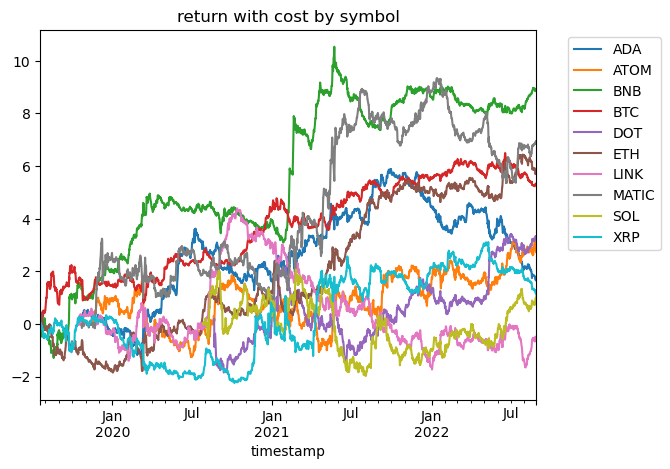

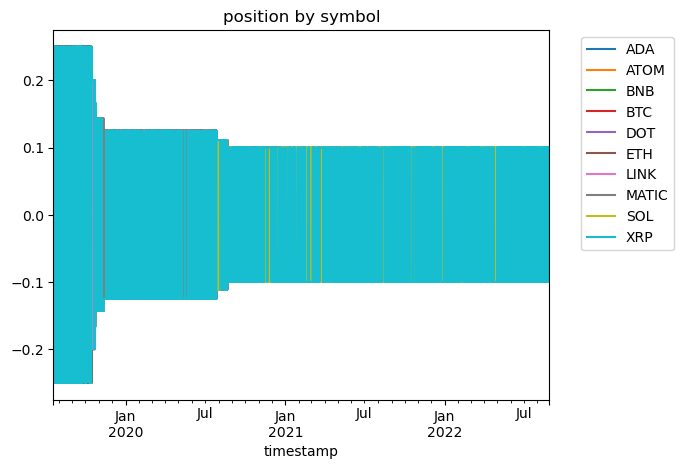

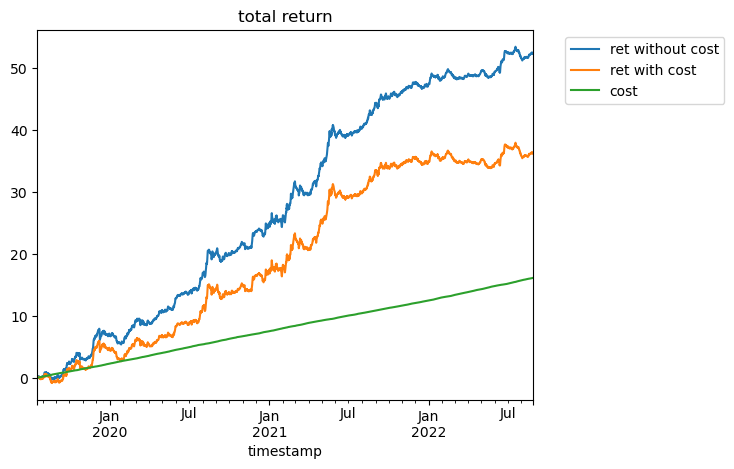

In [9]:
df = pd.read_pickle('/tmp/df.pkl')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model_rank.xz', 'wb') as f:
    f.write(data)

In [10]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model_rank.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)

timestamp                  symbol
2022-08-22 12:00:00+00:00  ADA       0.0
                           ATOM      0.0
                           BNB       0.0
                           BTC       0.0
                           DOT       0.0
                                    ... 
2022-08-29 12:00:00+00:00  ETH      -0.1
                           LINK      0.1
                           MATIC     0.1
                           SOL      -0.1
                           XRP      -0.1
Name: position, Length: 1690, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
